In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from datetime import timedelta
%matplotlib inline

In [2]:
world_poppercap = 7700000000 / 1000000
us_poppercap = 329877505 / 1000000
la_poppercap = 4648794 / 1000000

ticks = 10  #number of X ticks


In [3]:
def weekofyear(date):
    """
    Convert date to week of year for plotting weekly data
    Intended use for pandas.dataframe.map
    Need to be done before dropping yeah from date
    """
    dt = datetime.strptime(date, '%Y-%m-%d')
    return int(dt.strftime('%U'))


def rollingavg(y, days = 7):
    y = np.array(y)
    
    output = np.zeros((y.shape[0] * days), dtype=np.float64).reshape((y.shape[0],days))
        
    for idx in range(days,y.shape[0]):
        output[idx] = y[idx-days:idx]
    
    return np.mean(output,axis=1)
    
def newstats(df):
    """
        Changes daily totals to new cases and new deaths and adds them to dateframe
    """
    #changing daily totals to new cases
    newcases = np.zeros(df.shape[0], dtype=np.int32)
    newdeaths = np.zeros(df.shape[0], dtype=np.int32)
    deathscolumn = df.columns.get_loc('deaths')
    casescolumn = df.columns.get_loc('cases')

    newcases[0] = df.iloc[0,casescolumn]
    newdeaths[0] = df.iloc[0,deathscolumn]


    for idx in df.index[1:]:
        newcases[idx] = df.iloc[idx,casescolumn] - df.iloc[idx-1,casescolumn]
        newdeaths[idx] = df.iloc[idx,deathscolumn] - df.iloc[idx-1,deathscolumn]

    df['NewCases'] = newcases
    df['NewDeaths'] = newdeaths
    df['NewCasesRollAvg'] = rollingavg(newcases)
    df['NewDeathsRollAvg'] = rollingavg(newdeaths)

def drawindexofCDCdataloss(df,ax, color="magenta", label="CDC Loses Ctrl"):
    """
        Draws a line at the date where CDC took control of data
        
        Reference:  https://www.nytimes.com/2020/07/14/us/politics/trump-cdc-coronavirus.html
    """
    JudgementDate = '04-05'
    
    #for now this is being removed since the data has been out of CDCs hands for a long time and there are now alternative datasources in this project
    #ax.axvline(df[df['date']==JudgementDate].index.values[0],ymin=0, ymax=1,label=label, color=color,zorder=-100)
    
def getyTicks(df, columns, yticks=8):
    """
        Gets yTicks and returns labels
    """
    dfmax = np.max(df[columns])
    items_per_tick = dfmax / yticks
    out_yticks = np.arange(0,dfmax,items_per_tick)
    #axs[0].set_yticks(la_yticks)
    out_ticklabels = []
    for i in out_yticks:
        if i > 1000000:
            out_ticklabels.append("{0:,.3g}M".format(i/1000000.))
        elif i > 10000:
            out_ticklabels.append("{0:,.3g}K".format(i/1000.0))
        else:
            out_ticklabels.append("{0:,.0f}".format(i))

    return (out_yticks, out_ticklabels)
    
#This is to mark the dataset problem mentioned above

def LACFline(df,ax):
    """
        Adds a line for data adjustment to LA data on 6/19 mentioned above.  nytimes issues 377
    """
    
    idx = df[df['date']=='06-19'].index.values[0]
    line = ax.axvline(idx,ymin=0,ymax=1,color='r',label="LA Data Adjust", zorder=-100)
    
    return line

def holidays(df,ax):
    """
        Adds lines for major holiday
        
    """
    holidays_list = [
        ('03-25','Memorial Day'),
        ('07-04', '4th of July'),
        ('04-12','Easter'),
        ('09-07','Labor Day')
    ]
    
    label = "Holiday"
    for h in holidays_list:
        line = ax.axvline(df[df['date']==h[0]].index.values[0],ymin=0,ymax=1,color='pink',label=label, zorder=-100)
        label = None
    
    return line
    


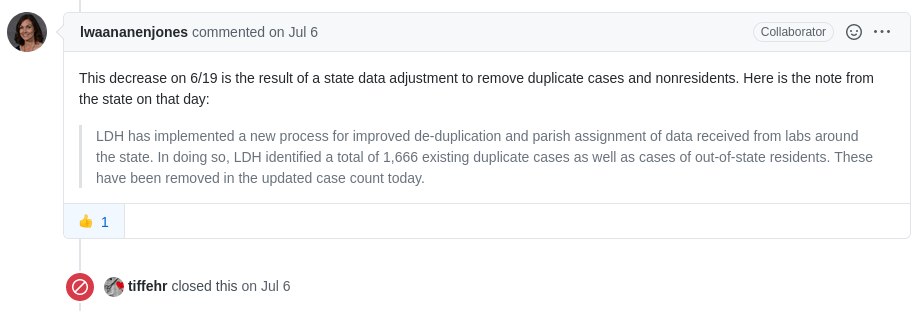

There was an issue with one of the days in louisiana which caused a negative result in the newcases for 6/19

https://github.com/nytimes/covid-19-data/issues/377

In [4]:
#state_df = pd.read_csv('./us-states.csv')
state_df = pd.read_csv('./covid-19-data/us-states.csv')  #moved nytimes data to submodule

la_df = state_df[state_df['state'] == 'Louisiana']
la_df = la_df.sort_values(['date'], ascending=True)

#week of year
la_df['week'] = la_df['date'].map(weekofyear)  #maybe this will be used again later


#shorten date
la_df['date'] = la_df['date'].map(lambda x: x[5:])

la_df['cases_ravg'] = rollingavg(la_df['cases'])
la_df['deaths_ravg'] = rollingavg(la_df['deaths'])

la_df.index = np.arange(la_df.shape[0])
newstats(la_df)

la_df['NewCasesPerCapita'] = la_df['NewCases'] / la_poppercap
la_df['NewDeathsPerCapita'] = la_df['NewDeaths'] / la_poppercap

la_df['NewCasesPerCapita_ravg'] = rollingavg(la_df['NewCasesPerCapita'])
la_df['NewDeathsPerCapita_ravg'] = rollingavg(la_df['NewDeathsPerCapita'])

la_items_pertick = la_df.shape[0] / ticks
la_ticks = np.append(np.arange(0,la_df.shape[0], la_items_pertick), [la_df.shape[0]-1])
la_items_pertick += 1


la_df.tail(2)


,date,state,fips,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
229,10-24,Louisiana,22,182603,5820,42,180153.285714,5774.857143,0,0,696.714286,13.285714,0.000000,0.000000,149.869899,2.857884
230,10-25,Louisiana,22,183575,5837,43,180850.000000,5788.142857,972,17,696.714286,13.285714,209.086486,3.656862,149.869899,2.857884


In [5]:
#us_df = pd.read_csv('./us.csv')
us_df = pd.read_csv('./covid-19-data/us.csv')  #movied nytimes/covid-19-data to submodule
us_df = us_df.sort_values('date')
us_df[us_df['date'] == '2020-03-09']

#slice to match up with Louisiana data for better comparison
us_df = us_df.iloc[48:,:]

#week of year
us_df['week'] = us_df['date'].map(weekofyear)  #maybe this will be used again later

#shorten date
us_df['date'] = us_df['date'].map(lambda x: x[5:])

us_df['cases_ravg'] = rollingavg(us_df['cases'])
us_df['deaths_ravg'] = rollingavg(us_df['deaths'])

us_df.index = np.arange(us_df.shape[0])
newstats(us_df)

us_df['NewCasesPerCapita'] = us_df['NewCases'] / us_poppercap
us_df['NewDeathsPerCapita'] = us_df['NewDeaths'] / us_poppercap

us_df['NewCasesPerCapita_ravg'] = rollingavg(us_df['NewCasesPerCapita'])
us_df['NewDeathsPerCapita_ravg'] = rollingavg(us_df['NewDeathsPerCapita'])

us_items_pertick = us_df.shape[0] / ticks
us_ticks = np.append(np.arange(0,us_df.shape[0], us_items_pertick),[us_df.shape[0]-1])
us_items_pertick += 1


us_df.tail(2)


,date,cases,deaths,week,cases_ravg,deaths_ravg,NewCases,NewDeaths,NewCasesRollAvg,NewDeathsRollAvg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
229,10-24,8642909,224819,42,8.349494e+06,221275.000000,78702,871,64420.857143,779.142857,238.579469,2.640374,195.287209,2.361916
230,10-25,8702600,225158,43,8.417621e+06,222081.571429,59691,339,68126.714286,806.571429,180.948986,1.027654,206.521249,2.445063


In [6]:
columns = ['date','new_cases','new_deaths','total_cases','total_deaths']
newcolumns = ['date','NewCases','NewDeaths','cases','deaths']  #set the columns to match the other dataframes

world_df = pd.read_csv('./owid-coviddata/public/data/owid-covid-data.csv')
world_df = world_df[world_df['iso_code'] == 'OWID_WRL'][columns]
world_df.columns = newcolumns

world_df = world_df.sort_values('date')
world_df.index = np.arange(world_df.shape[0])
world_df = world_df.iloc[world_df.index[world_df['date'] == '2020-03-09'][0]:,:]

world_df['week'] = world_df['date'].map(weekofyear)
world_df['date'] = world_df['date'].map(lambda x: x[5:])

world_df['NewCasesRollAvg'] = rollingavg(world_df['NewCases'])
world_df['NewDeathsRollAvg'] = rollingavg(world_df['NewDeaths'])

world_df['cases_ravg'] = rollingavg(world_df['cases'])
world_df['deaths_ravg'] = rollingavg(world_df['deaths'])

world_df.index = np.arange(world_df.shape[0])

world_df['NewCasesPerCapita'] = world_df['NewCases'] / world_poppercap
world_df['NewDeathsPerCapita'] = world_df['NewDeaths'] / world_poppercap

world_df['NewCasesPerCapita_ravg'] = rollingavg(world_df['NewCasesPerCapita'])
world_df['NewDeathsPerCapita_ravg'] = rollingavg(world_df['NewDeathsPerCapita'])

world_items_pertick = world_df.shape[0] / ticks
world_items_per_tick = world_df.shape[0] / ticks
world_ticks = np.append(np.arange(0,world_df.shape[0], world_items_pertick),[world_df.shape[0]-1])


world_df.tail(2)

,date,NewCases,NewDeaths,cases,deaths,week,NewCasesRollAvg,NewDeathsRollAvg,cases_ravg,deaths_ravg,NewCasesPerCapita,NewDeathsPerCapita,NewCasesPerCapita_ravg,NewDeathsPerCapita_ravg
230,10-25,446563.0,5761.0,42756915.0,1151155.0,43,410250.714286,5711.571429,4.098780e+07,1.126941e+06,57.995195,0.748182,53.279314,0.741763
231,10-26,383258.0,4080.0,43140173.0,1155235.0,43,421301.857143,5743.428571,4.140910e+07,1.132684e+06,49.773766,0.529870,54.714527,0.745900


In [7]:
df = pd.read_excel("./LaDeptHealth/LA_COVID_TESTBYDAY_PARISH_PUBLICUSE.xlsx")
df.head()

,Lab Collection Date,Parish,Daily Test Count,Daily Negative Test Count,Daily Positive Test Count,Daily Case Count,datetime
0,2020-03-01,Acadia,0,0,0,0,2020-03-01 12:00:00
1,2020-03-02,Acadia,0,0,0,0,2020-03-02 12:00:00
2,2020-03-03,Acadia,0,0,0,0,2020-03-03 12:00:00
3,2020-03-04,Acadia,0,0,0,0,2020-03-04 12:00:00
4,2020-03-05,Acadia,0,0,0,0,2020-03-05 12:00:00


In [8]:
parishes = sorted(df['Parish'].unique())
print(parishes)

['Acadia', 'Allen', 'Ascension', 'Assumption', 'Avoyelles', 'Beauregard', 'Bienville', 'Bossier', 'Caddo', 'Calcasieu', 'Caldwell', 'Cameron', 'Catahoula', 'Claiborne', 'Concordia', 'DeSoto', 'East Baton Rouge', 'East Carroll', 'East Feliciana', 'Evangeline', 'Franklin', 'Grant', 'Iberia', 'Iberville', 'Jackson', 'Jefferson', 'Jefferson Davis', 'LaSalle', 'Lafayette', 'Lafourche', 'Lincoln', 'Livingston', 'Madison', 'Morehouse', 'Natchitoches', 'Orleans', 'Ouachita', 'Plaquemines', 'Pointe Coupee', 'Rapides', 'Red River', 'Richland', 'Sabine', 'St. Bernard', 'St. Charles', 'St. Helena', 'St. James', 'St. John the Baptist', 'St. Landry', 'St. Martin', 'St. Mary', 'St. Tammany', 'Tangipahoa', 'Tensas', 'Terrebonne', 'Union', 'Vermilion', 'Vernon', 'Washington', 'Webster', 'West Baton Rouge', 'West Carroll', 'West Feliciana', 'Winn']


In [9]:
mindate = df['Lab Collection Date'].min()
print(mindate)

2020-03-01 00:00:00


In [10]:
maxdate = df['Lab Collection Date'].max()
print(maxdate)

2020-10-14 00:00:00


In [11]:
columns = []
dates_raw = np.sort(df['Lab Collection Date'].unique())

dates = sorted(np.datetime_as_string( dates_raw, unit='D'))
for date in dates_raw:
    columns.append(date)

rows_cases = []
rows_tests = []


for parish in parishes:
    parish_mask = df['Parish'] == parish
    
    casecount = []
    testcount = []

    for date in dates_raw:
        
        data = df[np.logical_and( parish_mask,  df['Lab Collection Date']==date)]
        casecount.append(data['Daily Case Count'].iloc[0])
        testcount.append(data['Daily Test Count'].iloc[0])
    
    
    
    assert len(casecount) == len(columns), "Outdata_cases len=%d, but columns len=%d" % (len(outdata),len(columns))
    assert len(testcount) == len(columns), "Outdata_tests len=%d, but columns len=%d" % (len(outdata),len(columns))
    rows_cases.append(casecount)
    rows_tests.append(testcount)


#rows_cases.append(outdata_cases)
#rows_tests.append(outdata_tests)
    
df_parish_cases = pd.DataFrame(rows_cases, columns=columns, index=parishes)
df_parish_tests = pd.DataFrame(rows_tests, columns=columns, index=parishes)
df_parish_cases.loc['Louisiana'] = df_parish_cases.sum()
df_parish_tests.loc['Louisiana'] = df_parish_tests.sum()


    

In [12]:
df_parish_cases.tail(2)

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14
Winn,0,0,0,0,0,0,0,0,0,0,...,1,6,0,1,3,0,0,2,6,1
Louisiana,0,0,0,0,0,0,0,1,5,11,...,855,639,689,550,391,316,289,753,652,562


In [13]:
df_parish_tests.tail(2)

,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14
Winn,0,0,0,0,0,0,0,0,0,0,...,36,211,146,51,19,2,4,38,191,24
Louisiana,1,0,1,1,3,4,6,3,30,50,...,23531,20131,18828,16297,11231,4652,4529,19452,18707,13975


In [14]:
df_population = pd.read_csv("./uscensus/co-est2019-alldata.csv" ,encoding='latin1')
df_population = df_population[df_population['STNAME'] == 'Louisiana']
df_population.index = df_population['CTYNAME'].str.replace(" Parish","")
orleans_population = df_population.loc['Orleans']['POPESTIMATE2019']
la_population = df_population.loc['Louisiana']['POPESTIMATE2019']
ebr_population = df_population.loc['East Baton Rouge']['POPESTIMATE2019']

In [15]:
def processparishdf(parish):
    populationpercap = df_population.loc[parish]['POPESTIMATE2019'] / 1000000
    
    df = pd.DataFrame( df_parish_cases.columns, columns=['date'])
    df['date'] = df['date'].map(lambda x: "%4d-%.2d-%.2d" % (x.year,x.month,x.day))
    df['week'] = df['date'].map(weekofyear)
    df['date'] = df['date'].map(lambda x: x[5:])
    
    df['NewCases'] = df_parish_cases.loc[parish].values
    df['NewCasesRollAvg'] = rollingavg(df['NewCases'])
    
    cases = []
    cases_num = 0
    for row in df.iterrows():
        cases_num += row[1][2]
        cases.append(cases_num)
    
    df['cases'] = cases
    df['cases_ravg'] = rollingavg(df['cases'])
    
    df['NewCasesPerCapita'] = df['NewCases'] / populationpercap
    df['NewCasesPerCapita_ravg'] = rollingavg(df['NewCasesPerCapita'])
    df = df.iloc[8:,:]
    
    df.index = np.arange(df.shape[0])
    
    items_pertick = df.shape[0] / ticks
    out_ticks = np.append(np.arange(0,df.shape[0], items_pertick), [df.shape[0]-1])
    items_pertick += 1
    
    return (df, out_ticks)
    
(orleans_df, orleans_ticks) = processparishdf('Orleans')
(ebr_df, ebr_ticks) = processparishdf('East Baton Rouge')
(la2_df,la2_ticks) = processparishdf('Louisiana')
(tamm_df,tamm_ticks) = processparishdf('St. Tammany')
    
orleans_df.tail(2)

,date,week,NewCases,NewCasesRollAvg,cases,cases_ravg,NewCasesPerCapita,NewCasesPerCapita_ravg
218,10-13,41,38,30.714286,13266,13135.857143,97.399934,78.725511
219,10-14,41,41,31.428571,13307,13167.285714,105.089403,80.556337


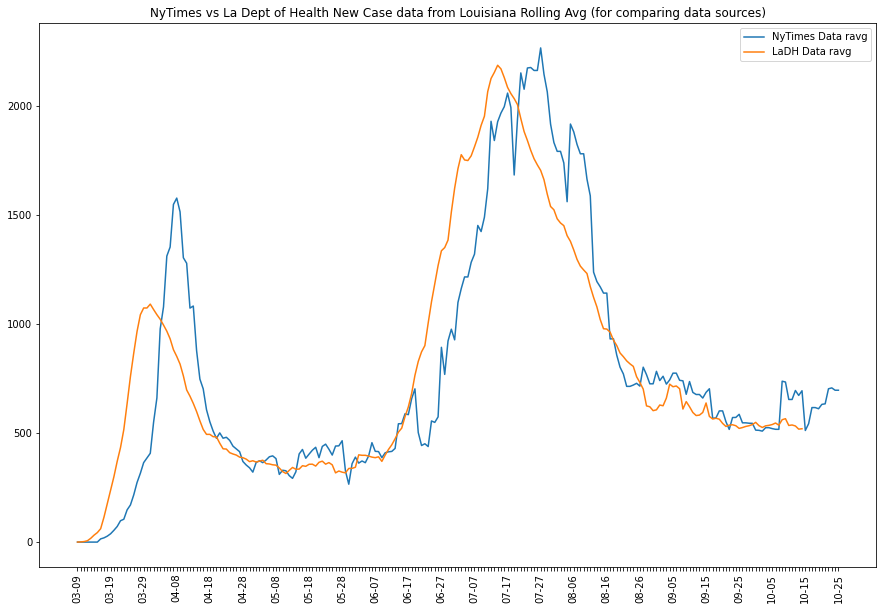

In [16]:
fig,axs = plt.subplots(figsize=(15,10))

#axs.plot(la_df['date'],la_df['NewCases'], label='NyTimes Data')
#axs.plot(la2_df['date'],la2_df['NewCases'], label='LaDH Data')

axs.plot(la_df['date'],la_df['NewCasesRollAvg'], label='NyTimes Data ravg')
axs.plot(la2_df['date'],la2_df['NewCasesRollAvg'], label='LaDH Data ravg')
axs.legend()

idx = 0
for label in axs.xaxis.get_ticklabels():
    
    if idx % 10 != 0:
        label.set_visible(False)
        
    idx = idx+1

axs.tick_params(axis='x', rotation=90)
axs.set_title("NyTimes vs La Dept of Health New Case data from Louisiana Rolling Avg (for comparing data sources)")

fig.savefig("fig9.jpg")

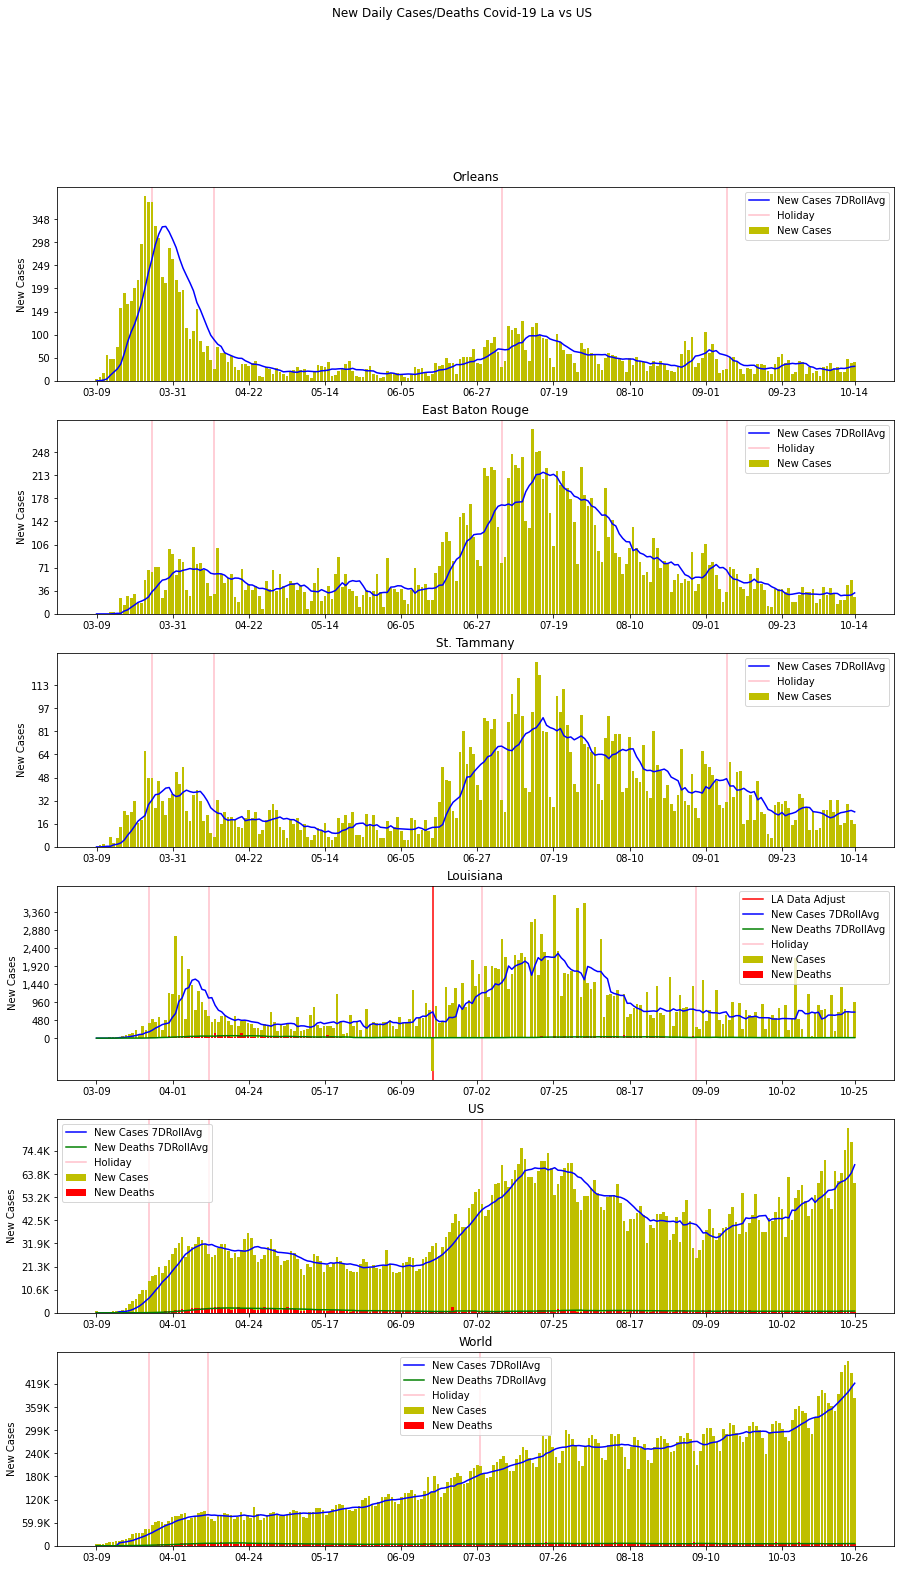

In [17]:
#Figure 1
fig, axs = plt.subplots(6, figsize=(15,25))

def plotme(df, ax,xticks,addeaths=True):
    


    ax.bar(df.index,df['NewCases'], color='y', label='New Cases')
    ax.plot(df.index,df['NewCasesRollAvg'], color = 'b',label='New Cases 7DRollAvg')
    
    if addeaths:
        ax.bar(df.index,df['NewDeaths'], color='r', label='New Deaths')
        ax.plot(df.index,df['NewDeathsRollAvg'], color = 'g', label='New Deaths 7DRollAvg')

    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()
    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    
axs[0].title.set_text('Orleans')
#LACFline(orleans_df,axs[0])
plotme(orleans_df,axs[0],orleans_ticks, addeaths=False)

axs[1].title.set_text("East Baton Rouge")
plotme(ebr_df,axs[1],ebr_ticks,addeaths=False)

axs[2].title.set_text("St. Tammany")
plotme(tamm_df,axs[2],tamm_ticks,addeaths=False)

axs[3].title.set_text('Louisiana')
#adjustments for LA data issue 4/19
LACFline(la_df,axs[3])
plotme(la_df,axs[3],la_ticks)

axs[4].title.set_text('US')
plotme(us_df,axs[4],us_ticks)

axs[5].title.set_text('World')
plotme(world_df,axs[5],world_ticks)

fig.suptitle("New Daily Cases/Deaths Covid-19 La vs US")

plt.savefig("fig1.jpg")


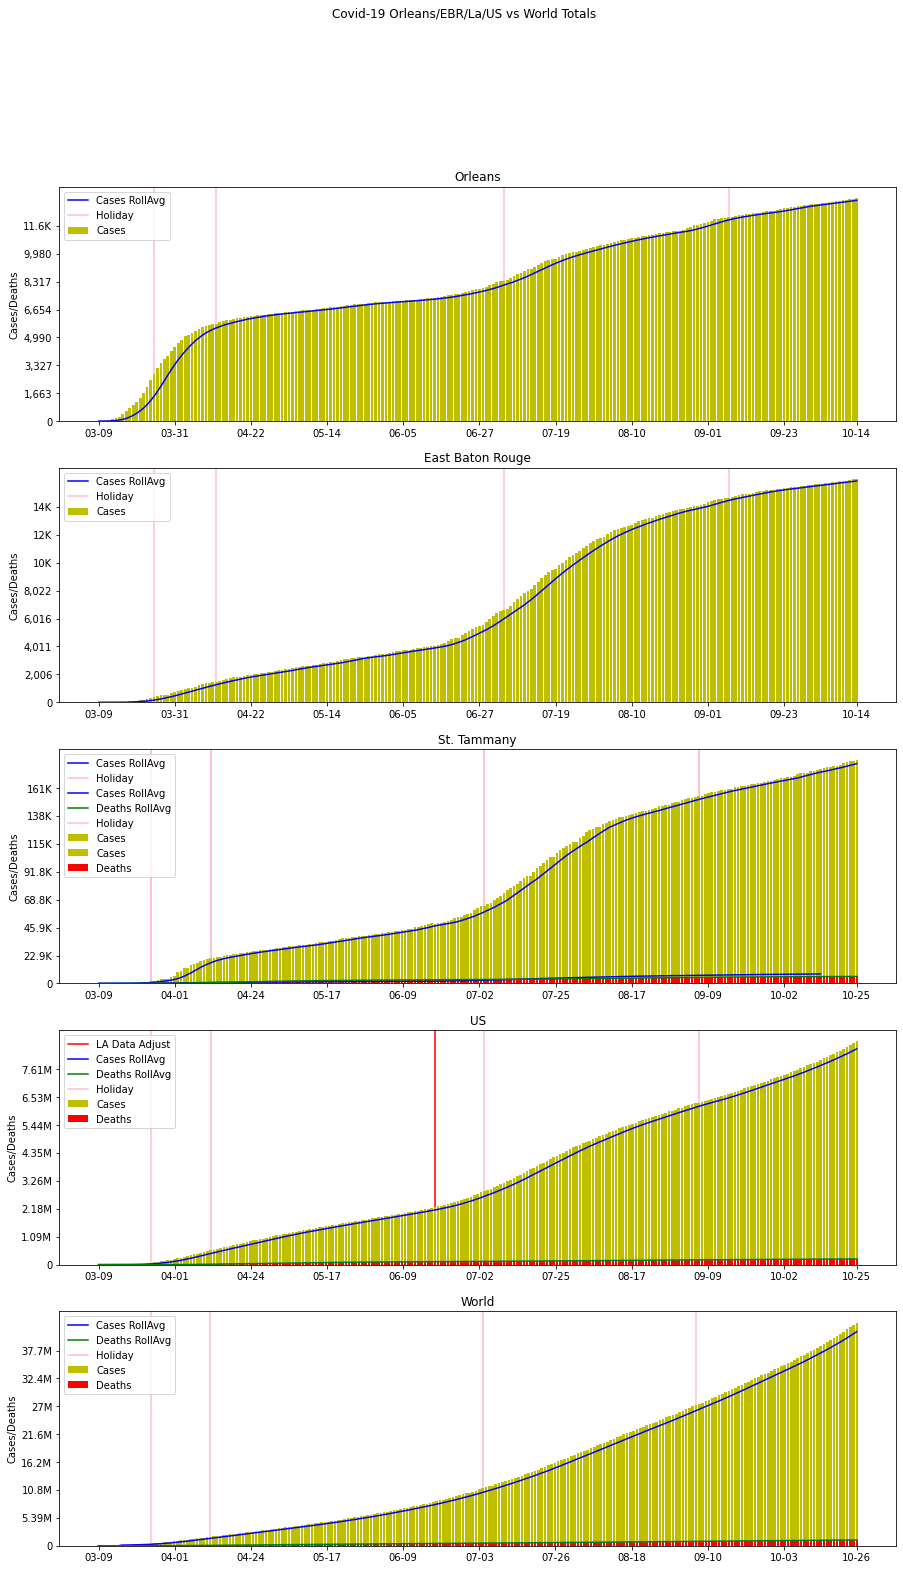

In [18]:
#Figure 2
fig, axs = plt.subplots(5, figsize=(15,25))

def plotme(df,ax, xticks, addeaths = True):
    ax.bar(df.index,df['cases'], color='y', label='Cases')
    ax.plot(df.index,df['cases_ravg'], color = 'b',label='Cases RollAvg')
    
    if addeaths:
        ax.bar(df.index,df['deaths'], color='r', label='Deaths')
        ax.plot(df.index,df['deaths_ravg'], color = 'g', label='Deaths RollAvg')
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()
    

    yticks,yticklabels = getyTicks(df,'cases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("Cases/Deaths")

axs[0].title.set_text("Orleans")
plotme(orleans_df,axs[0],orleans_ticks, addeaths=False)

axs[1].title.set_text("East Baton Rouge")
plotme(ebr_df,axs[1],ebr_ticks, addeaths=False)

axs[2].title.set_text("St. Tammany")
plotme(tamm_df,axs[2],tamm_ticks,addeaths=False)

axs[3].title.set_text('Louisiana')
#adjustments for LA data issue 4/19
LACFline(la_df,axs[3])

plotme(la_df,axs[2],la_ticks)    

axs[3].title.set_text('US')
plotme(us_df,axs[3],us_ticks)

axs[4].title.set_text("World")
plotme(world_df,axs[4],world_ticks)

fig.suptitle("Covid-19 Orleans/EBR/La/US vs World Totals")

plt.savefig("fig2.jpg")

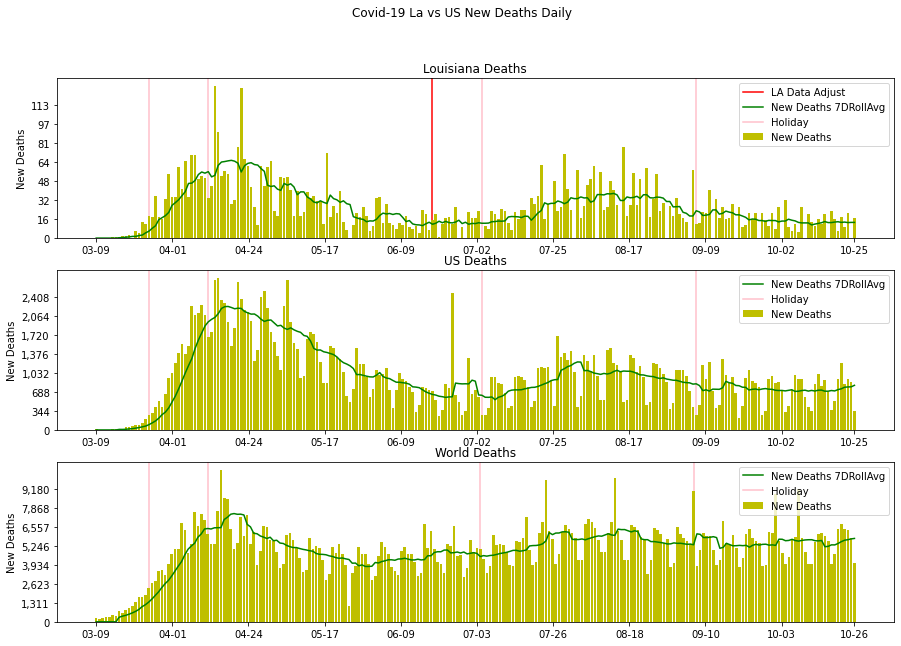

In [19]:
#Figure 3

fig, axs = plt.subplots(3, figsize=(15,10))

def plotme(df,ax,xticks):

    ax.bar(df.index,df['NewDeaths'], color = 'y', label="New Deaths")
    ax.plot(df.index,df['NewDeathsRollAvg'], color='g', label="New Deaths 7DRollAvg")
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    drawindexofCDCdataloss(df,ax)
    holidays(df,ax)
    ax.legend()

    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")

axs[0].title.set_text('Louisiana Deaths')

#adjustments for LA data issue 4/19
LACFline(la_df,axs[0])

plotme(la_df,axs[0],la_ticks)


axs[1].title.set_text('US Deaths')
plotme(us_df,axs[1],us_ticks)

axs[2].title.set_text('World Deaths')
plotme(world_df,axs[2],world_ticks)

fig.suptitle("Covid-19 La vs US New Deaths Daily")

plt.savefig("fig3.jpg")

In [20]:
orleans_df_weekly = pd.DataFrame(orleans_df.groupby('week')['NewCases'].sum())
ebr_df_weekly = pd.DataFrame(ebr_df.groupby('week')['NewCases'].sum())
tamm_df_weekly = pd.DataFrame(tamm_df.groupby('week')['NewCases'].sum())
la_df_weekly = la_df.groupby('week')[['NewCases','NewDeaths']].sum()
us_df_weekly = us_df.groupby('week')[['NewCases','NewDeaths']].sum()
world_df_weekly = world_df.groupby('week')[['NewCases','NewDeaths']].sum()

weeks_rollingavg = 3

orleans_df_weekly['NewCasesRollAvg'] = rollingavg(orleans_df_weekly['NewCases'], weeks_rollingavg)
ebr_df_weekly['NewCasesRollAvg'] = rollingavg(ebr_df_weekly['NewCases'], weeks_rollingavg)
tamm_df_weekly['NewCasesRollAvg'] = rollingavg(tamm_df_weekly['NewCases'], weeks_rollingavg)
la_df_weekly['NewCasesRollAvg'] = rollingavg(la_df_weekly['NewCases'], weeks_rollingavg)
us_df_weekly['NewCasesRollAvg'] = rollingavg(us_df_weekly['NewCases'], weeks_rollingavg)
world_df_weekly['NewCasesRollAvg'] = rollingavg(world_df_weekly['NewCases'], weeks_rollingavg)

la_df_weekly['NewDeathsRollAvg'] = rollingavg(la_df_weekly['NewDeaths'], weeks_rollingavg)
us_df_weekly['NewDeathsRollAvg'] = rollingavg(us_df_weekly['NewDeaths'], weeks_rollingavg)
world_df_weekly['NewDeathsRollAvg'] = rollingavg(world_df_weekly['NewDeaths'], weeks_rollingavg)


orleans_df.tail()
#us_df_weekly.tail(2)

,date,week,NewCases,NewCasesRollAvg,cases,cases_ravg,NewCasesPerCapita,NewCasesPerCapita_ravg
215,10-10,40,19,27.285714,13160,13050.000000,48.699967,69.937547
216,10-11,41,20,26.857143,13180,13076.857143,51.263123,68.839051
217,10-12,41,48,28.285714,13228,13105.142857,123.031496,72.500703
218,10-13,41,38,30.714286,13266,13135.857143,97.399934,78.725511
219,10-14,41,41,31.428571,13307,13167.285714,105.089403,80.556337


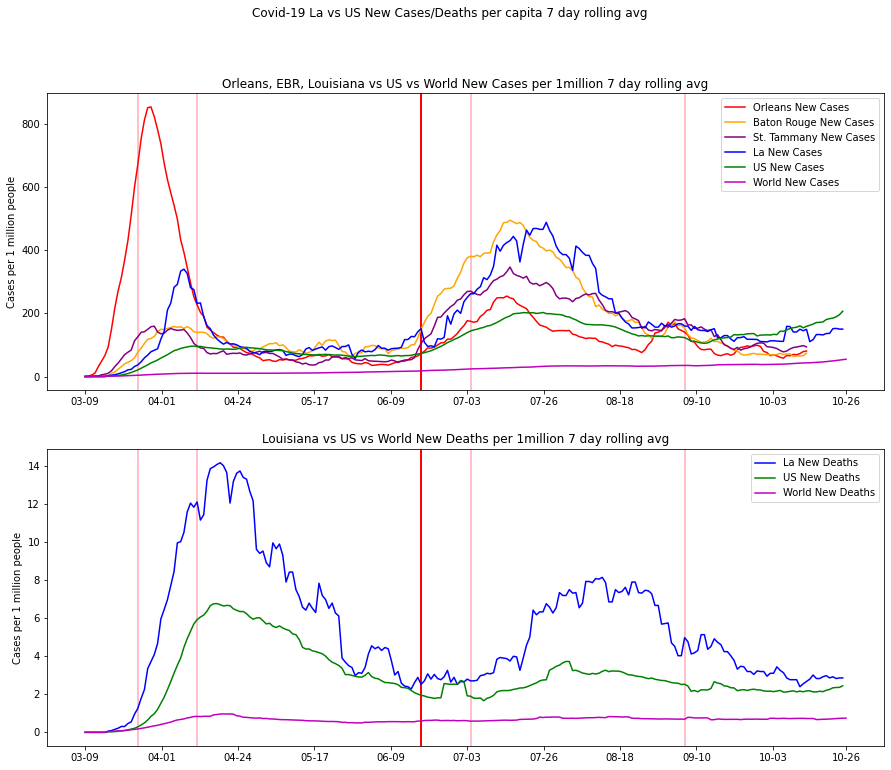

In [21]:
#Figure 4

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    ax.set_ylabel("Cases per 1 million people")
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    
    
    
    return lines
    
    
fig, axs = plt.subplots(2, figsize=(15,12))

ax1lines = []
ax2lines = []

ax1lines.append( plotme(orleans_df,axs[0],orleans_ticks,'NewCasesPerCapita_ravg',"Orleans New Cases", color = 'r')[0][0])
ax1lines.append( plotme(ebr_df,axs[0],ebr_ticks,'NewCasesPerCapita_ravg',"Baton Rouge New Cases", color = 'orange')[0][0])
ax1lines.append( plotme(tamm_df,axs[0],orleans_ticks,'NewCasesPerCapita_ravg',"St. Tammany New Cases", color = 'purple')[0][0])
for col,ax in zip([('NewCasesPerCapita_ravg','New Cases'),('NewDeathsPerCapita_ravg', 'New Deaths')],((axs[0],ax1lines),(axs[1],ax2lines))):
    
    ax[1].append( plotme(la_df,ax[0],la_ticks, col[0],"La %s" % col[1], color='b')[0][0])
    ax[1].append( plotme(us_df,ax[0],us_ticks, col[0],'US %s' % col[1], color='g')[0][0])
    ax[1].append( plotme(world_df,ax[0],world_ticks,col[0],"World %s" % col[1], color='m')[0][0])
    
axs[0].legend(handles=ax1lines)
axs[1].legend(handles=ax2lines)
    
    

axs[0].title.set_text('Orleans, EBR, Louisiana vs US vs World New Cases per 1million 7 day rolling avg')
axs[1].title.set_text('Louisiana vs US vs World New Deaths per 1million 7 day rolling avg')


fig.suptitle("Covid-19 La vs US New Cases/Deaths per capita 7 day rolling avg ")

plt.savefig("fig4.jpg")

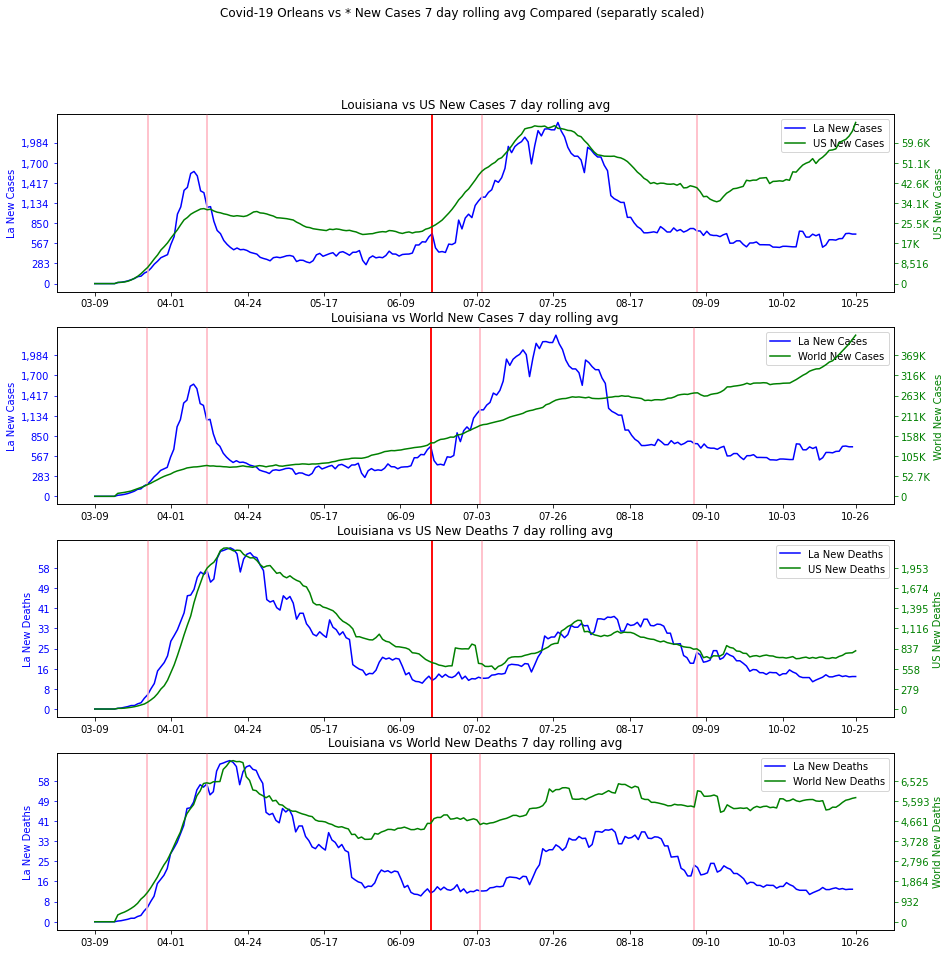

In [22]:
#Figure 5

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    yticks,yticklabels = getyTicks(df,column)
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(label,color=color)
    ax.tick_params(axis='y',color=color,labelcolor=color)
    
    return lines
    
    
fig, axs = plt.subplots(4, figsize=(15,15))

idx = 0
for col, label in zip(['NewCasesRollAvg','NewDeathsRollAvg'], ['New Cases','New Deaths']):
    for compare_place, label_place in zip([(us_df,us_ticks),(world_df,world_ticks)], ['US','World']):
        line1 = plotme(la_df,axs[idx],la_ticks, col,"La %s" % label, color='b')
        axsY2 = axs[idx].twinx()
        line2 = plotme(compare_place[0],axsY2,compare_place[1], col,"%s %s" % (label_place, label), color='g')
        axs[idx].legend(handles=[line1[0][0],line2[0][0]])
        axs[idx].title.set_text("Louisiana vs %s %s 7 day rolling avg"%(label_place,label))
        idx += 1
    
fig.suptitle("Covid-19 Orleans vs * New Cases 7 day rolling avg Compared (separatly scaled)")

plt.savefig("fig5.jpg")

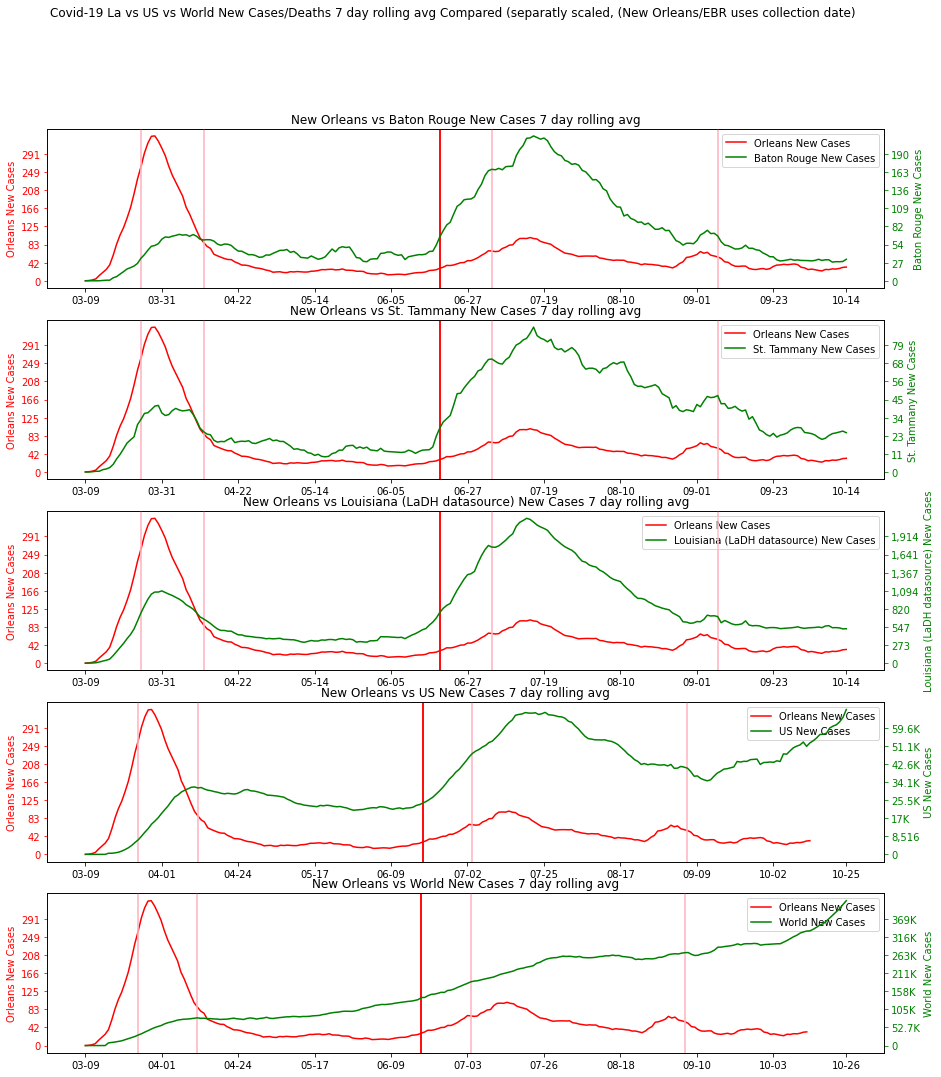

In [23]:
#Figure 5

#problem with the legend need to work on this
def plotme(df,ax,xticks, column, label, color = 'r'):
    lines = []
    
    lines.append(ax.plot(df.index,df[column],color=color, label=label))
    ax.set_xticks(xticks)
    ax.set_xticklabels(df.iloc[xticks,0])
    
    drawindexofCDCdataloss(df,ax)
    lines.append(holidays(df,ax))
    lines.append(LACFline(df,ax))   #I'm not sure the data for deaths and cases was effected by the adjustment
    
    yticks,yticklabels = getyTicks(df,column)
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel(label,color=color)
    ax.tick_params(axis='y',color=color,labelcolor=color)
    
    return lines
    
    
fig, axs = plt.subplots(5, figsize=(15,17))

idx = 0
col = 'NewCasesRollAvg'
label = 'New Cases'
for compare_place, label_place in zip([(ebr_df,ebr_ticks),(tamm_df,tamm_ticks), (la2_df,la2_ticks), (us_df,us_ticks),(world_df,world_ticks)], ['Baton Rouge', 'St. Tammany','Louisiana (LaDH datasource)','US','World']):
    line1 = plotme(orleans_df,axs[idx],orleans_ticks, col,"Orleans %s" % label, color='r')
    axsY2 = axs[idx].twinx()
    line2 = plotme(compare_place[0],axsY2,compare_place[1], col,"%s %s" % (label_place, label), color='g')
    axs[idx].legend(handles=[line1[0][0],line2[0][0]])
    axs[idx].title.set_text("New Orleans vs %s %s 7 day rolling avg"%(label_place,label))
    idx += 1

fig.suptitle("Covid-19 La vs US vs World New Cases/Deaths 7 day rolling avg Compared (separatly scaled, (New Orleans/EBR uses collection date)")

plt.savefig("fig8.jpg")

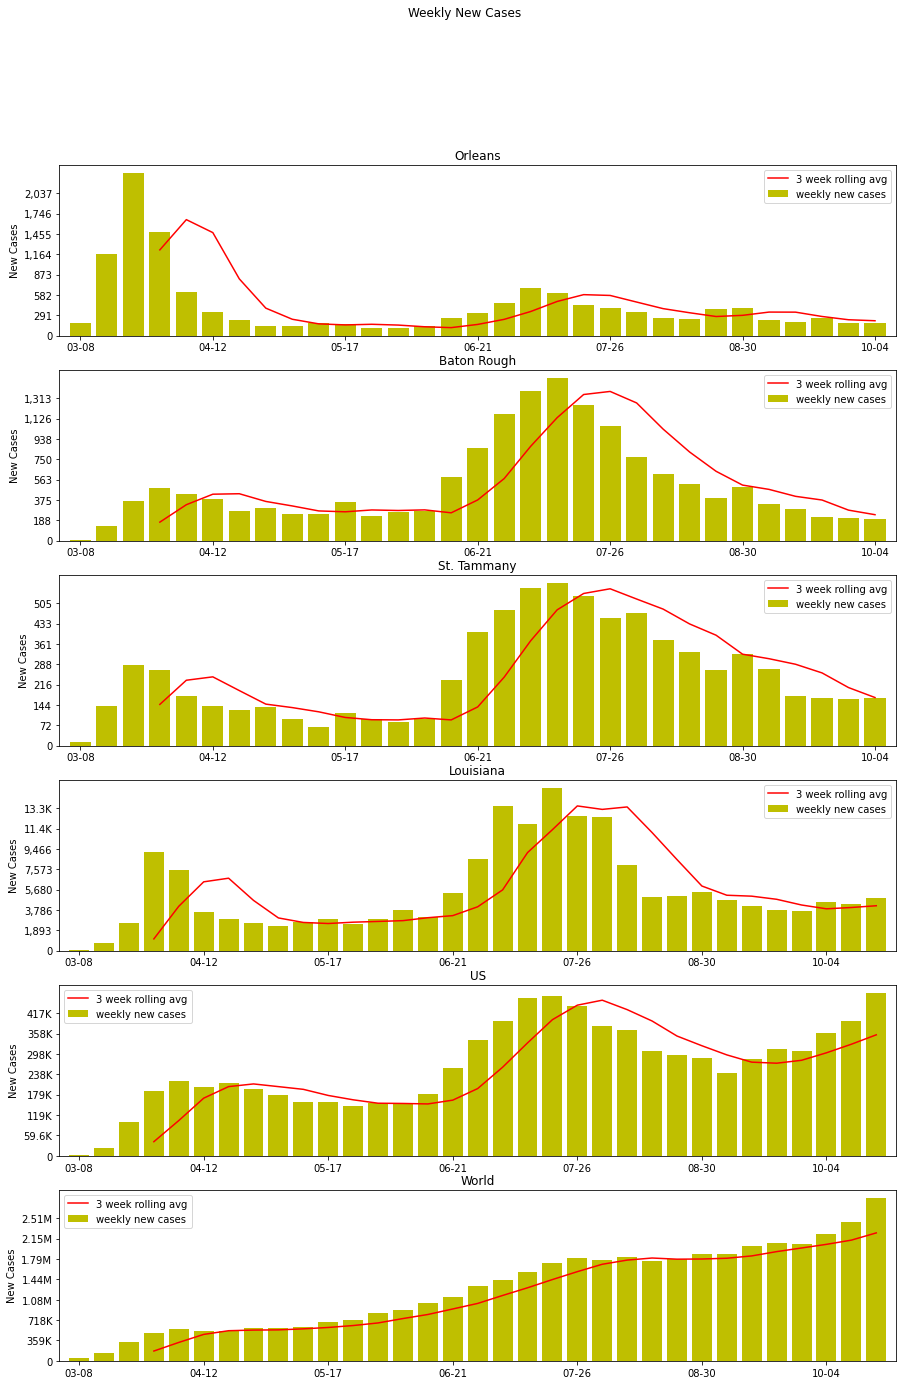

In [24]:
#Figure 6

def plotme(df,ax, title = "Graphs", color = 'y', linecolor = 'r'):
    ax.bar(df.index[:-1],df['NewCases'][:-1], color=color, label='weekly new cases')
    ax.plot(df.index[weeks_rollingavg:-1],df['NewCasesRollAvg'][weeks_rollingavg:-1], color=linecolor, label='%d week rolling avg' % weeks_rollingavg)
    
    ax.set_title(title)
    #ax.set_xlabel("Week")
    
    yticks,yticklabels = getyTicks(df,'NewCases')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Cases")
    
    weeks = ax.get_xticks()
    labels = [datetime.strptime("2020-%s-0" % str(int(week)).zfill(2), "%Y-%U-%w").strftime("%m-%d") for week in weeks]
    ax.set_xticks(weeks)
    ax.set_xticklabels(labels)
    ax.set_xlim(df.index[0]-ax.patches[0].get_width(),df.index[-2]+ax.patches[0].get_width())
    ax.legend()
      
fig, axs = plt.subplots(6, figsize=(15,22))
fig.suptitle("Weekly New Cases")

plotme(orleans_df_weekly,axs[0], title="Orleans")
plotme(ebr_df_weekly,axs[1],title="Baton Rough")
plotme(tamm_df_weekly,axs[2],title="St. Tammany")
plotme(la_df_weekly,axs[3], title="Louisiana")
plotme(us_df_weekly,axs[4], title="US")
plotme(world_df_weekly,axs[5],title="World")

plt.savefig("fig6.jpg")

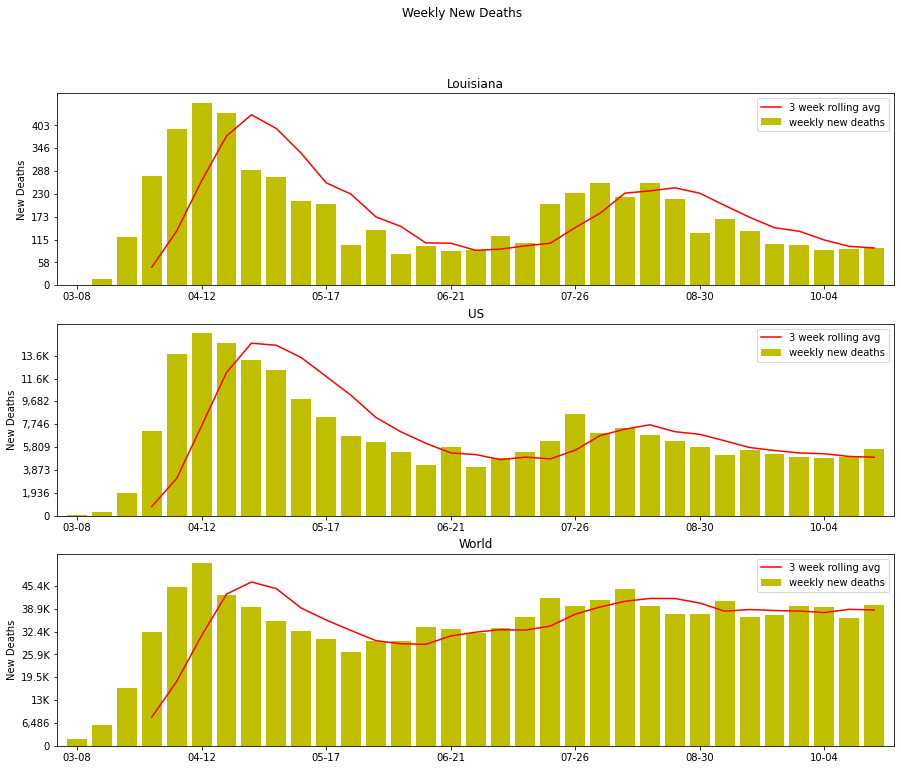

In [25]:
#Figure 7

def plotme(df,ax, title = "Graphs", color = 'y', linecolor='r'):
    ax.bar(df.index[:-1],df['NewDeaths'][:-1], color=color, label='weekly new deaths')
    ax.plot(df.index[weeks_rollingavg:-1],df['NewDeathsRollAvg'][weeks_rollingavg:-1], color=linecolor, label='%d week rolling avg' % weeks_rollingavg)
    
    ax.set_title(title)
    #ax.set_xlabel("Week")
    
    yticks,yticklabels = getyTicks(df,'NewDeaths')
    ax.set_yticks(yticks)        
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("New Deaths")
    weeks = ax.get_xticks()
    labels = [datetime.strptime("2020-%s-0" % str(int(week)).zfill(2), "%Y-%U-%w").strftime("%m-%d") for week in weeks]
    ax.set_xticks(weeks)
    ax.set_xticklabels(labels)
    ax.set_xlim(df.index[0]-ax.patches[0].get_width(),df.index[-2]+ax.patches[0].get_width())
    ax.legend()
    
fig, axs = plt.subplots(3, figsize=(15,12))
fig.suptitle("Weekly New Deaths")

plotme(la_df_weekly,axs[0], title="Louisiana")
plotme(us_df_weekly,axs[1], title="US")
plotme(world_df_weekly,axs[2],title="World")

plt.savefig("fig7.jpg")